In [1]:
from obspy import UTCDateTime
from obspy import Trace
from obspy import Stream
from obspy import read_inventory
from obspy.clients.fdsn import Client
client = Client("https://tdvms.afad.gov.tr/continuous_data")
starttime = UTCDateTime("2023-02-05T23:59:59")
endtime = UTCDateTime("2023-02-06T04:00:00")
inventory = client.get_waveforms(network="TK", station="3125", location="*", channel="??E",
                                starttime=starttime,
                                endtime=endtime)
print(inventory)


XMLSyntaxError: StartTag: invalid element name, line 38, column 19 (<string>, line 38)

6 Trace(s) in Stream:
...          | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.000000Z | 1.0 Hz, 0 samples
AV.DOL..BHE  | 2021-07-29T06:15:47.000000Z - 2021-07-29T06:20:47.000000Z | 1.0 Hz, 301 samples
AV.PS1A..BHE | 2021-07-29T06:15:47.000000Z - 2021-07-29T06:20:46.000000Z | 1.0 Hz, 300 samples
AV.PS4A..BHE | 2021-07-29T06:15:47.000000Z - 2021-07-29T06:20:46.000000Z | 1.0 Hz, 300 samples
AV.SSLN..BHE | 2021-07-29T06:15:47.000000Z - 2021-07-29T06:20:47.000000Z | 1.0 Hz, 301 samples
AV.WESE..BHE | 2021-07-29T06:15:47.000000Z - 2021-07-29T06:20:47.000000Z | 1.0 Hz, 301 samples


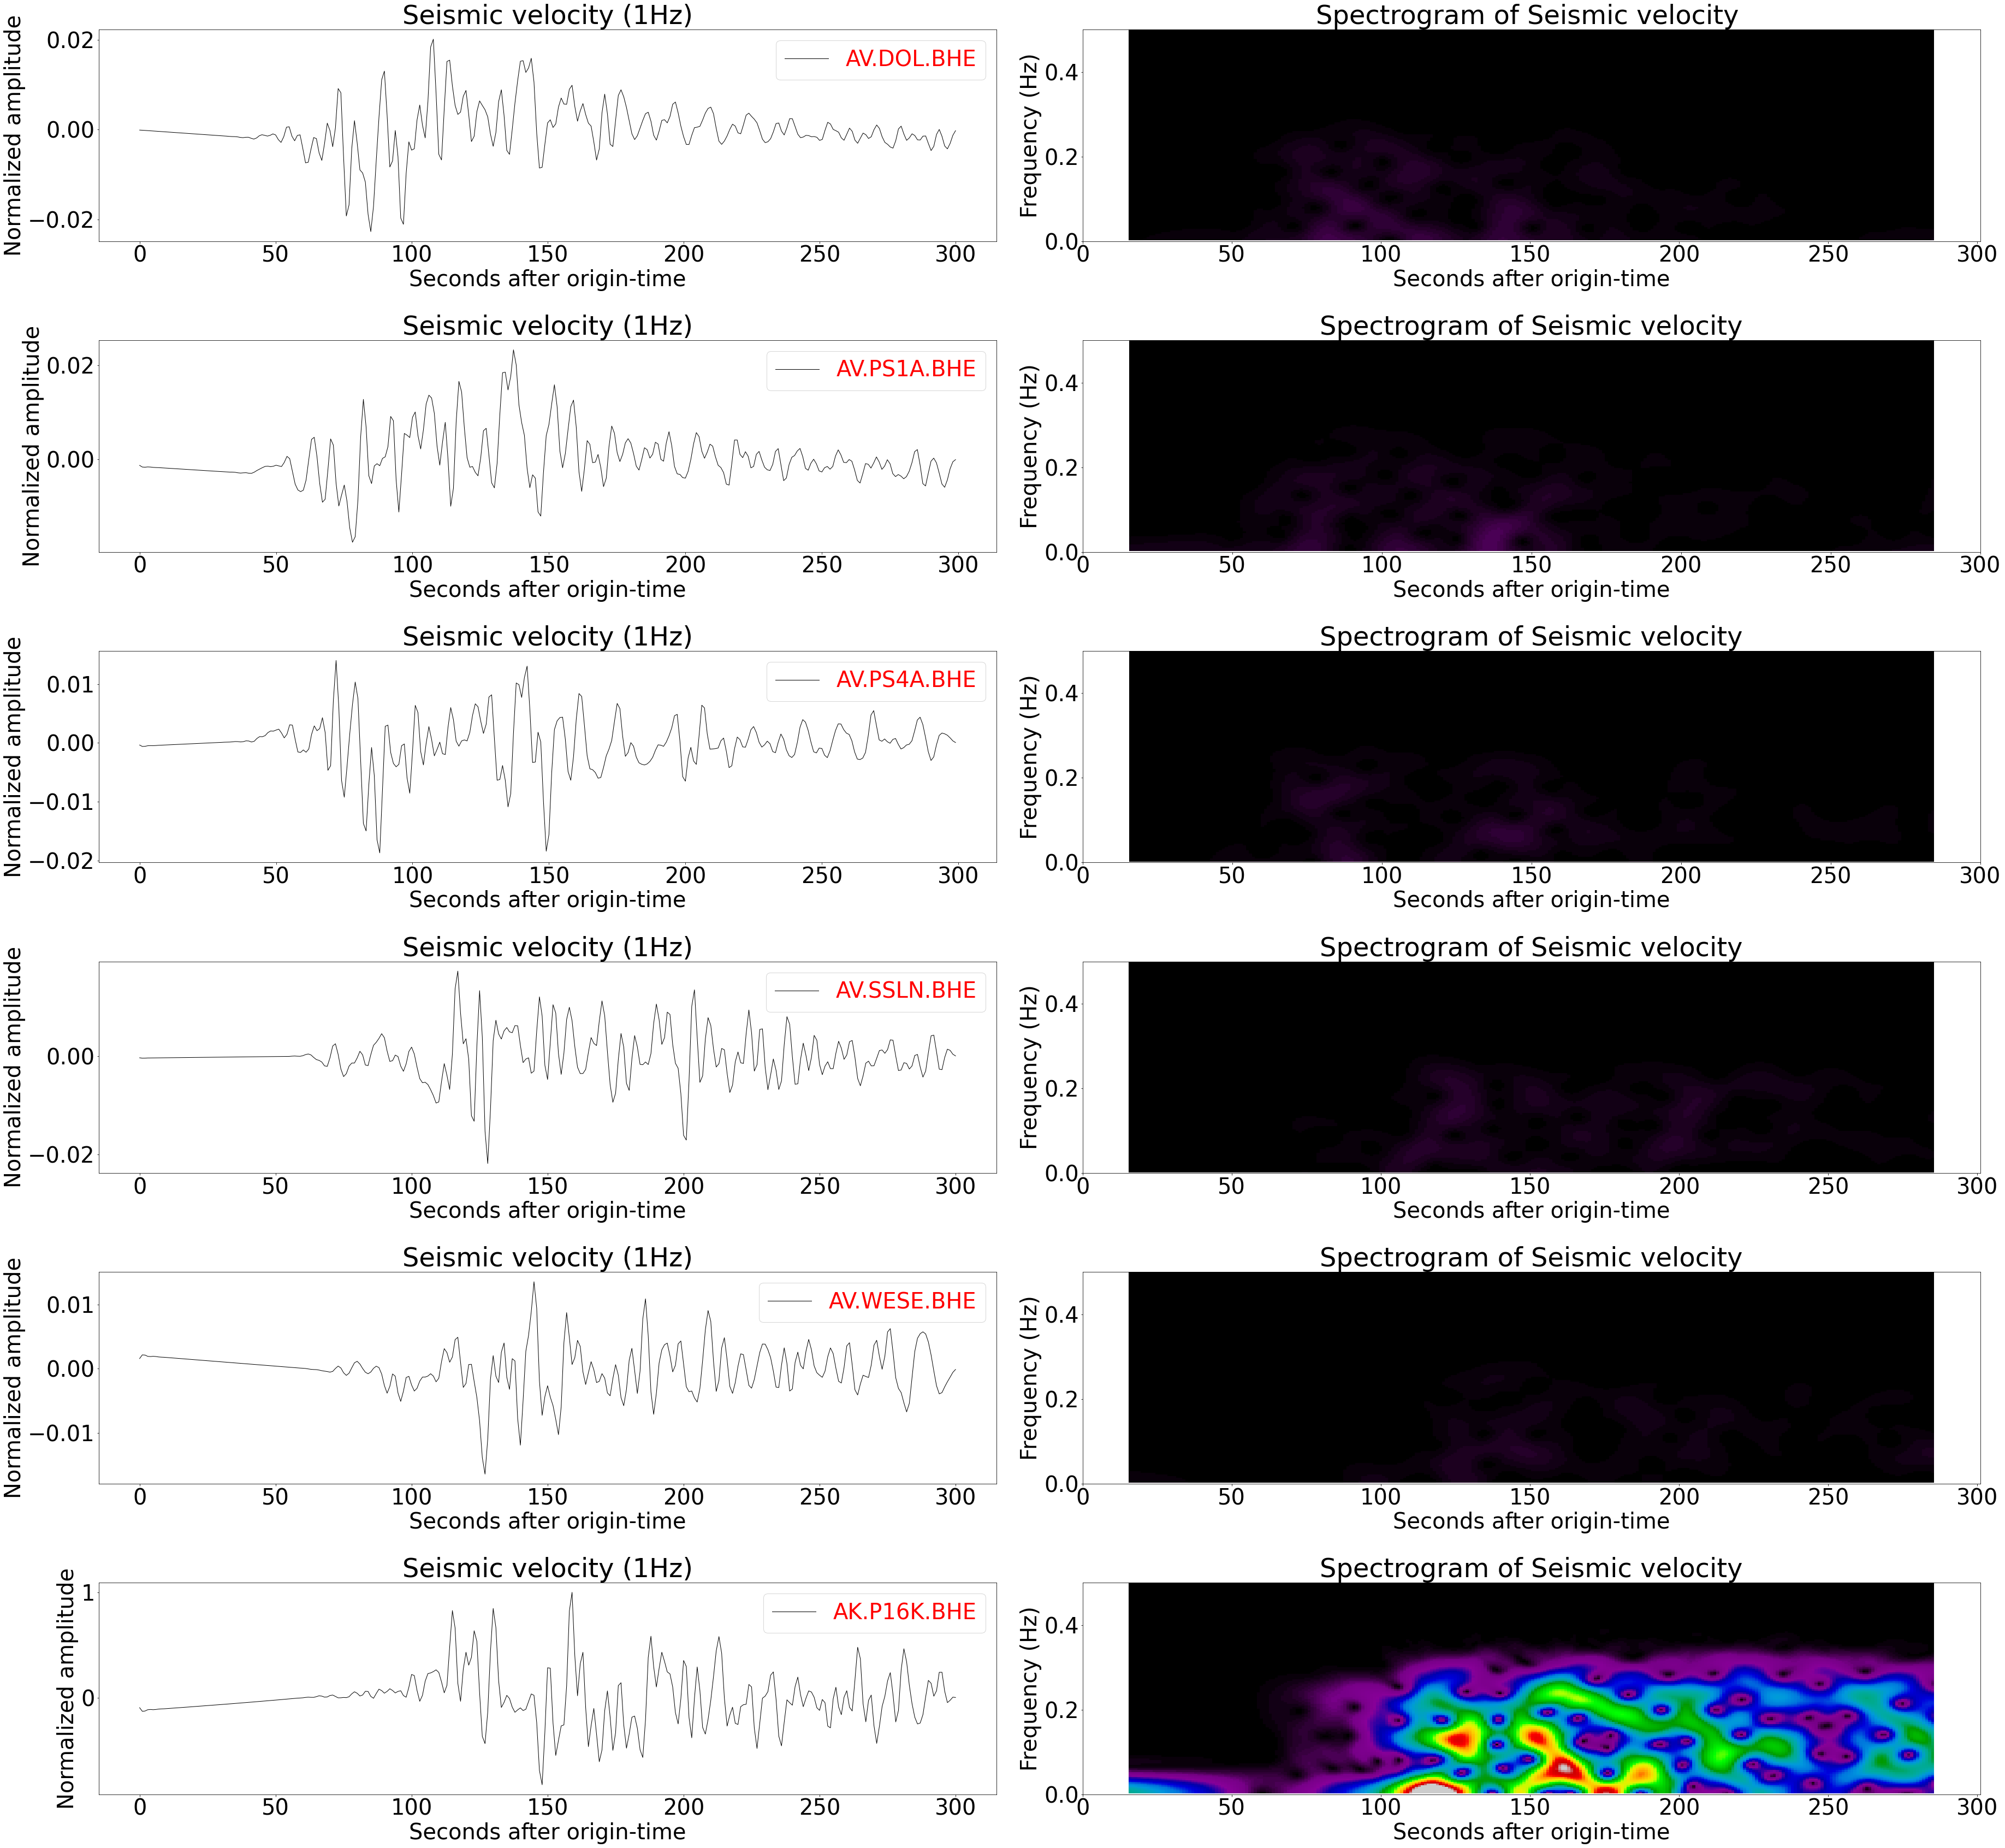

In [1]:
######## GNSS instavel Vs strong-motion derived velocity analysis and plots ##################
################################## Scipy version #############################################
####################################### Goals ################################################
#     1) Read a GNSS instavel and convert it into an obspy stream
#     2) Filter instavel
#     3) Load acceleration from IRIS client
#     4) Filter and integrate strong-motion acceleration to corresponding velocity
#     5) Subtract/find difference between GNSS and strong motion veocity
#     6) Subtract the difference from GNSS and plot trace
#     7) cross-correlate and plot both versions
##############################################################################################

from obspy import UTCDateTime 				
from obspy import Trace
from obspy import Stream
from obspy import read_inventory
from obspy.signal.cross_correlation import correlate
from obspy.clients.fdsn import Client 		
client=Client("IRIS")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.cm as cmx
import datetime

# READ INSTAVEL ASCII FILE
st = Stream(Trace())
# "DOL", "P16K", "PS1A", "PS4A", "SSLN", "WESE", 
for sta in ["3125", "PS1A", "PS4A", "SSLN", "WESE"]:
    start = UTCDateTime("2021-07-29T06:15:47.000000Z")
    seis_v = client.get_waveforms('AV', f'{sta}', "*", 'BHE', (start), (start+300), attach_response=True)
    seis_v[0].remove_response(inventory=None, output="ACC", plot=False)
    seis_v[0].detrend('linear')
    hz = seis_v[0].data[::50]
# CREATE AN EMPTY STREAM AND POPULATE WITH INSTAVEL DATA1
    st_sm = Trace()
    st_sm.stats.network = 'AV'
    st_sm.stats.station = f'{sta}'
    st_sm.stats.channel = 'BHE'       
    st_sm.stats.starttime = UTCDateTime("2021-07-29T06:15:47.0Z")
    st_sm.stats.sampling_rate = 1
    st_sm.stats.calib = 1
    st_sm.data = hz
    st_sm.filter('bandpass', freqmin=0.001, freqmax=0.25, corners=4, zerophase=True)
#    st_sm.normalize()
    st += Stream([st_sm])

print(st)
#print(st[1])
#print(st[2])

start = UTCDateTime("2021-07-29T06:15:47.000000Z")
seis_vk = client.get_waveforms('AK', 'P16K', "*", 'BHE', (start), (start+300), attach_response=True)
seis_vk[0].remove_response(inventory=None, output="VEL", plot=False)
seis_vk[0].detrend('linear')
hzk = seis_vk[0].data[::50]
# CREATE AN EMPTY STREAM AND POPULATE WITH INSTAVEL DATA1
st_smk = Trace()
st_smk.stats.network = 'AK'
st_smk.stats.station = 'P16K'
st_smk.stats.channel = 'BHE'       
st_smk.stats.starttime = UTCDateTime("2021-07-29T06:15:47.0Z")
st_smk.stats.sampling_rate = 1
st_smk.stats.calib = 1
st_smk.data = hzk
st_smk.filter('bandpass', freqmin=0.001, freqmax=0.25, corners=4, zerophase=True)
st_smk.normalize()

# CREATE STREAMS WITH ALL TRACES AND PLOT THEM
plt.rcParams['figure.figsize'] = [52,48]
plt.rcParams.update({'font.size': 40})
#plt.style.use('seaborn')

fig, ax = plt.subplots(6,2)
ax[0,0].plot(st[1].times(), st[1].data, 'k-', linewidth=1, 
             label=(st[1].stats['network'])+'.'+(st[1].stats['station'])+'.'+(st[1].stats['channel']))
ax[0,0].set_title(f'Seismic velocity (1Hz)')
ax[0,0].set_ylabel('Normalized amplitude')
ax[0,0].set_xlabel('Seconds after origin-time', fontsize=40)
ax[1,0].plot(st[2].times(), st[2].data, 'k-', linewidth=1, 
             label=(st[2].stats['network'])+'.'+(st[2].stats['station'])+'.'+(st[2].stats['channel']))
ax[1,0].set_title(f'Seismic velocity (1Hz)')
ax[1,0].set_ylabel('Normalized amplitude')
ax[1,0].set_xlabel('Seconds after origin-time')
ax[2,0].plot(st[3].times(), st[3].data, 'k-', linewidth=1, 
             label=(st[3].stats['network'])+'.'+(st[3].stats['station'])+'.'+(st[3].stats['channel']))
ax[2,0].set_title(f'Seismic velocity (1Hz)')
ax[2,0].set_ylabel('Normalized amplitude')
ax[2,0].set_xlabel('Seconds after origin-time')
ax[3,0].plot(st[4].times(), st[4].data, 'k-', linewidth=1, 
             label=(st[4].stats['network'])+'.'+(st[4].stats['station'])+'.'+(st[4].stats['channel']))
ax[3,0].set_title(f'Seismic velocity (1Hz)')
ax[3,0].set_ylabel('Normalized amplitude')
ax[3,0].set_xlabel('Seconds after origin-time')
ax[4,0].plot(st[5].times(), st[5].data, 'k-', linewidth=1, 
             label=(st[5].stats['network'])+'.'+(st[5].stats['station'])+'.'+(st[5].stats['channel']))
ax[4,0].set_title(f'Seismic velocity (1Hz)')
ax[4,0].set_ylabel('Normalized amplitude')
ax[4,0].set_xlabel('Seconds after origin-time')
ax[5,0].plot(st_smk.times(), st_smk.data, 'k-', linewidth=1, 
             label=(st_smk.stats['network'])+'.'+(st_smk.stats['station'])+'.'+(st_smk.stats['channel']))
ax[5,0].set_title(f'Seismic velocity (1Hz)')
ax[5,0].set_ylabel('Normalized amplitude')
ax[5,0].set_xlabel('Seconds after origin-time')
#ax[6,0].plot(st[7].times(), st[7].data, 'k-', linewidth=1, 
#             label=(st[7].stats['network'])+'.'+(st[7].stats['station'])+'.'+(st[7].stats['channel']))
#ax[6,0].set_title(f'Instantaneous GNSS velocity (1Hz)')
#ax[6,0].set_ylabel('Normalized amplitude')
#ax[6,0].set_xlabel('Seconds after origin-time')

st[1].spectrogram(axes=ax[0,1], show=True, samp_rate=st[1].stats.sampling_rate, 
                  per_lap=0.99, wlen=30, log=False, cmap='nipy_spectral')

ax[0, 1].set_title(f'Spectrogram of Seismic velocity ')
ax[0, 1].set_ylabel('Frequency (Hz)')
ax[0, 1].set_xlabel('Seconds after origin-time')
ax[0, 1].set_ylim((0,0.5))
ax[0, 1].images[0].set_clim(vmin=0, vmax=1.5)
#mappable = ax[0,1].images[0]
#ax13 = fig.add_axes([0.99, 0.412, 0.01, 0.21])
#plt.colorbar(mappable=mappable, cax=ax13)

st[2].spectrogram(axes=ax[1,1], show=True, samp_rate=st[2].stats.sampling_rate, 
                  per_lap=0.99, wlen=30, log=False, cmap='nipy_spectral')
ax[1, 1].set_title(f'Spectrogram of Seismic velocity')
ax[1, 1].set_ylabel('Frequency (Hz)')
ax[1, 1].set_xlabel('Seconds after origin-time')
ax[1, 1].set_ylim((0,0.5))
ax[1, 1].images[0].set_clim(vmin=0, vmax=1.5)
#mappable = ax[1,1].images[0]
#ax23 = fig.add_axes([0.92, 0.738, 0.01, 0.21])
#plt.colorbar(mappable=mappable, cax=ax23)

st[3].spectrogram(axes=ax[2,1], show=True, samp_rate=st[3].stats.sampling_rate, 
                  per_lap=0.99, wlen=30, log=False, cmap='nipy_spectral')
ax[2, 1].set_title(f'Spectrogram of Seismic velocity')
ax[2, 1].set_ylabel('Frequency (Hz)')
ax[2, 1].set_xlabel('Seconds after origin-time')
ax[2, 1].set_ylim((0,0.5))
ax[2, 1].images[0].set_clim(vmin=0, vmax=1.5)

st[4].spectrogram(axes=ax[3,1], show=True, samp_rate=st[4].stats.sampling_rate, 
                  per_lap=0.99, wlen=30, log=False, cmap='nipy_spectral')
ax[3, 1].set_title(f'Spectrogram of Seismic velocity')
ax[3, 1].set_ylabel('Frequency (Hz)')
ax[3, 1].set_xlabel('Seconds after origin-time')
ax[3, 1].set_ylim((0,0.5))
ax[3, 1].images[0].set_clim(vmin=0, vmax=1.5)

st[5].spectrogram(axes=ax[4,1], show=True, samp_rate=st[5].stats.sampling_rate, 
                  per_lap=0.99, wlen=30, log=False, cmap='nipy_spectral')
ax[4, 1].set_title(f'Spectrogram of Seismic velocity')
ax[4, 1].set_ylabel('Frequency (Hz)')
ax[4, 1].set_xlabel('Seconds after origin-time')
ax[4, 1].set_ylim((0,0.5))
ax[4, 1].images[0].set_clim(vmin=0, vmax=1.5)

st_smk.spectrogram(axes=ax[5,1], show=True, samp_rate=st_smk.stats.sampling_rate, 
                  per_lap=0.99, wlen=30, log=False, cmap='nipy_spectral')
ax[5, 1].set_title(f'Spectrogram of Seismic velocity')
ax[5, 1].set_ylabel('Frequency (Hz)')
ax[5, 1].set_xlabel('Seconds after origin-time')
ax[5, 1].set_ylim((0,0.5))
ax[5, 1].images[0].set_clim(vmin=0, vmax=1.5)

#st[7].spectrogram(axes=ax[6,1], show=True, samp_rate=st[7].stats.sampling_rate, 
#                  per_lap=0.99, wlen=30, log=False, cmap='nipy_spectral')
#ax[6, 1].set_title(f'Spectrogram of instavel')
#ax[6, 1].set_ylabel('Frequency (Hz)')
#ax[6, 1].set_xlabel('Seconds after origin-time')
#ax[6, 1].set_ylim((0,0.5))
#ax[6, 1].images[0].set_clim(vmin=0, vmax=1.5)

plt.tight_layout()

# TRACE LEGENDS
for row in ax[:,0]:
    ll = row.legend(loc=1)
    plt.setp(ll.get_texts(), color='red') #color legend
#for row in ax[:,1]:
#    ll = row.legend(loc=1)
#    plt.setp(ll.get_texts(), color='red') #color legend

#ll = ax[1,1].legend(loc=1)
#plt.setp(ll.get_texts(), color='red') #color legend

plt.show()
fig.savefig("SM_freq_filt.png")
